1 . Data preprocessing and helper functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx
import seaborn as sns
import numpy as np

/data2/home/shyamsg/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
DATA_PATH = Path() / "../data"

#ensure the data directory exists
DATA_PATH.mkdir(parents=True,exist_ok=True)

# To load data in excel format
def load_excel(filename, data_path=DATA_PATH):
    csv_path = data_path / filename
    return pd.read_excel(csv_path)

PLOT_PATH = Path() / "../plot_mine1"

#ensure the plot directory exists
PLOT_PATH.mkdir(parents=True,exist_ok=True)

# To save plots in png format
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)


In [3]:
data = load_excel('final_dataset.xlsx')

from IPython.display import display
# display(data)

print(data.shape)

#KOL-Key opnion leaders-15
KOL_list = data['name_kol'].drop_duplicates().reset_index(drop = True).to_list()

data_cleaned = data.dropna(subset=['name_kol'])
len(data_cleaned)

(3642, 38)


3641

In [4]:
reformat_data = data_cleaned[['screenName_kol', 'userId_kol', 'name_kol',
       'imgUrl_kol', 'bio_kol', 'website_kol', 'location_kol', 'createdAt_kol',
       'followersCount_kol', 'friendsCount_kol', 'tweetsCount_kol',
       'screenName_fo', 'userId_fo', 'name_fo', 'imgUrl_fo',
       'bio_fo', 'website_fo', 'location', 'location_cleansed', 'createdAt_fo',
       'followersCount_fo', 'friendsCount_fo', 'tweetsCount_fo',
       'certified_fo', 'timestamp_fo', 'if personal account', 'Position', 'Organization',
       'ai_related', 'position_categorized', 'highest_level_org',
       'following_fo'
       # 'Frequency', 'Include?', 'row_id', 
       ]]

reformat_data['following_fo'] = reformat_data['following_fo'].fillna(0)
reformat_data['following_fo'].value_counts()
print(reformat_data.shape)

(3641, 32)


/tmp/ipykernel_763768/1044876562.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reformat_data['following_fo'] = reformat_data['following_fo'].fillna(0)


### Q0. Is the dataset potential to find the current and emergent influencers in ai Field.

1. In the dataset among the KOLs get distribution of job categories of users they are following
2. This give the insigth on weather data is potential or not


In [5]:
data['position_categorized']=data['position_categorized'].replace({
    'Company Members': 'Company Members',
    'Company members': 'Company Members'
})

#merge position and ai related column
data['merged_position'] = data['position_categorized'].astype(str) + ' - ' + data['ai_related'].astype(str)
data['merged_position'] = data['merged_position'].replace({
    'Company Members - Y': 'Company Members - Y',
    'Company members - Y': 'Company Members - Y'
})

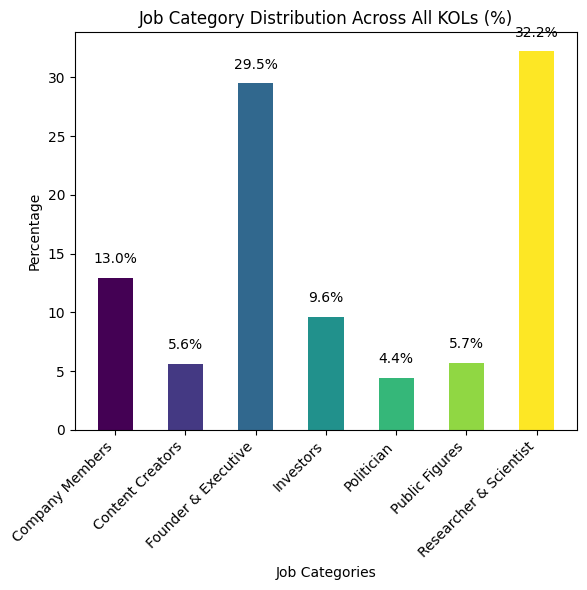

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_position_distribution_with_percentages(grouped_data, attribute):
    # Count the frequency of each job category across all KOLs
    category_counts = grouped_data[attribute].value_counts()
    # Calculate percentages
    category_percentages = category_counts / category_counts.sum() * 100
    # Sort the categories for consistent plotting
    category_counts_sorted = category_counts.sort_index()
    category_percentages_sorted = category_percentages.sort_index()
    
    # Define colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(category_counts_sorted)))
    
    # Plot the distribution with percentages and colors
    plt.figure(figsize=(6, 6))
    bars = plt.bar(category_counts_sorted.index, category_percentages_sorted.values, color=colors,width=0.5)
    
    # Adding the percentages on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{round(yval, 1)}%', ha='center', va='bottom')
    
    plt.title('Job Category Distribution Across All KOLs (%)')
    plt.ylabel('Percentage')
    plt.xlabel('Job Categories')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot the combined position distribution with percentages for all KOLs
plot_combined_position_distribution_with_percentages(data, 'position_categorized')

### Q1. Popular users and their distribution of occupation and location

1. Construct a directed graph G1 (nodes : users , edge : A-->B if A follows B)  
2. Calculate indegree and eigenvector centrality measures of all nodes (to visualize).
3. According to indegree centrality find top - K popular users.
4. Using data[position_categorized] of that popular user find the dist of occupation,location


Number of nodes: 1459
Number of edges: 3626


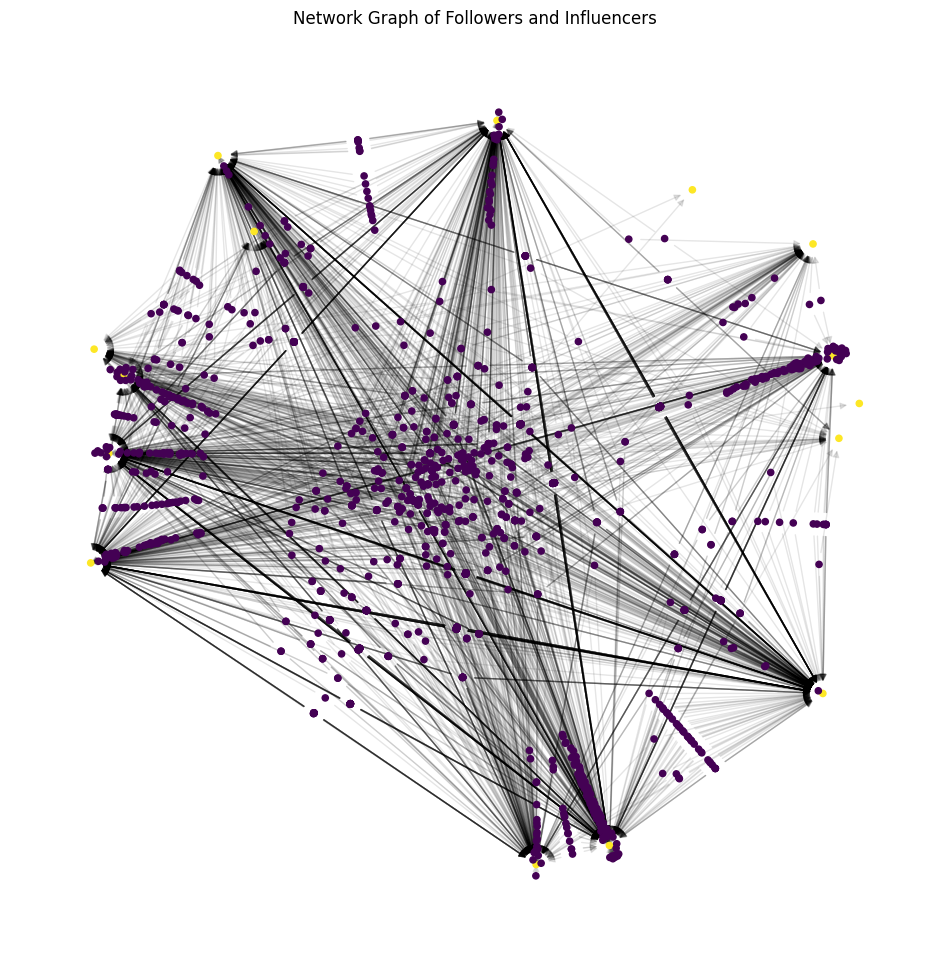

In [7]:
# Create a directed graph
G1 = nx.DiGraph()

# Adding nodes and edges from the dataset
# We use name_fo for follower nodes and screenName_kol for influencer nodes
for _, row in data_cleaned[['name_fo', 'screenName_kol']].dropna().iterrows():
    G1.add_node(row['name_fo'], type='follower')
    G1.add_node(row['screenName_kol'], type='influencer')
    G1.add_edge(row['name_fo'], row['screenName_kol'])

# for index, row in reformat_data.iterrows():
#     G2.add_node(row['screenName_kol'], type='influencer')
#     G2.add_node(row['name_fo'], type='following')
#     G2.add_edge(row['screenName_kol'], row['name_fo'], follow_back=row['following_fo'])

# i want to know number of nodes and edges in the graph G1
print('Number of nodes:', G1.number_of_nodes())
print('Number of edges:', G1.number_of_edges())

# Visualizing the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G1, seed=42)  # Positions for all nodes
nx.draw_networkx_nodes(G1, pos, node_size=20, node_color=[G1.nodes[n]['type'] == 'influencer' for n in G1])
nx.draw_networkx_edges(G1, pos, alpha=0.1)
plt.title('Network Graph of Followers and Influencers')
plt.axis('off')  # Turn off the axis
# save_fig('network_graph1')
plt.show()

In [8]:
# Calculate network metrics
degree_centrality = nx.degree_centrality(G1)
in_degree_centrality = nx.in_degree_centrality(G1)
out_degree_centrality = nx.out_degree_centrality(G1)
betweenness_centrality = nx.betweenness_centrality(G1)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G1)
clossness_centrality = nx.closeness_centrality(G1)

# Prepare the data for display
centrality_measures1 = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'In-Degree Centrality': in_degree_centrality,
    'Out-Degree Centrality': out_degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Eigenvector Centrality': eigenvector_centrality,
    'Closeness Centrality': clossness_centrality
})

centrality_measures1.shape
top50_nodes_by_in_degree = centrality_measures1.sort_values(by='In-Degree Centrality', ascending=False).head(50)
centrality_measures1['In-Degree Centrality'].describe()

count    1459.000000
mean        0.001705
std         0.020955
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.371056
Name: In-Degree Centrality, dtype: float64

In [9]:
top50_nodes_by_in_degree.shape

(50, 6)

Saving figure influencers_network


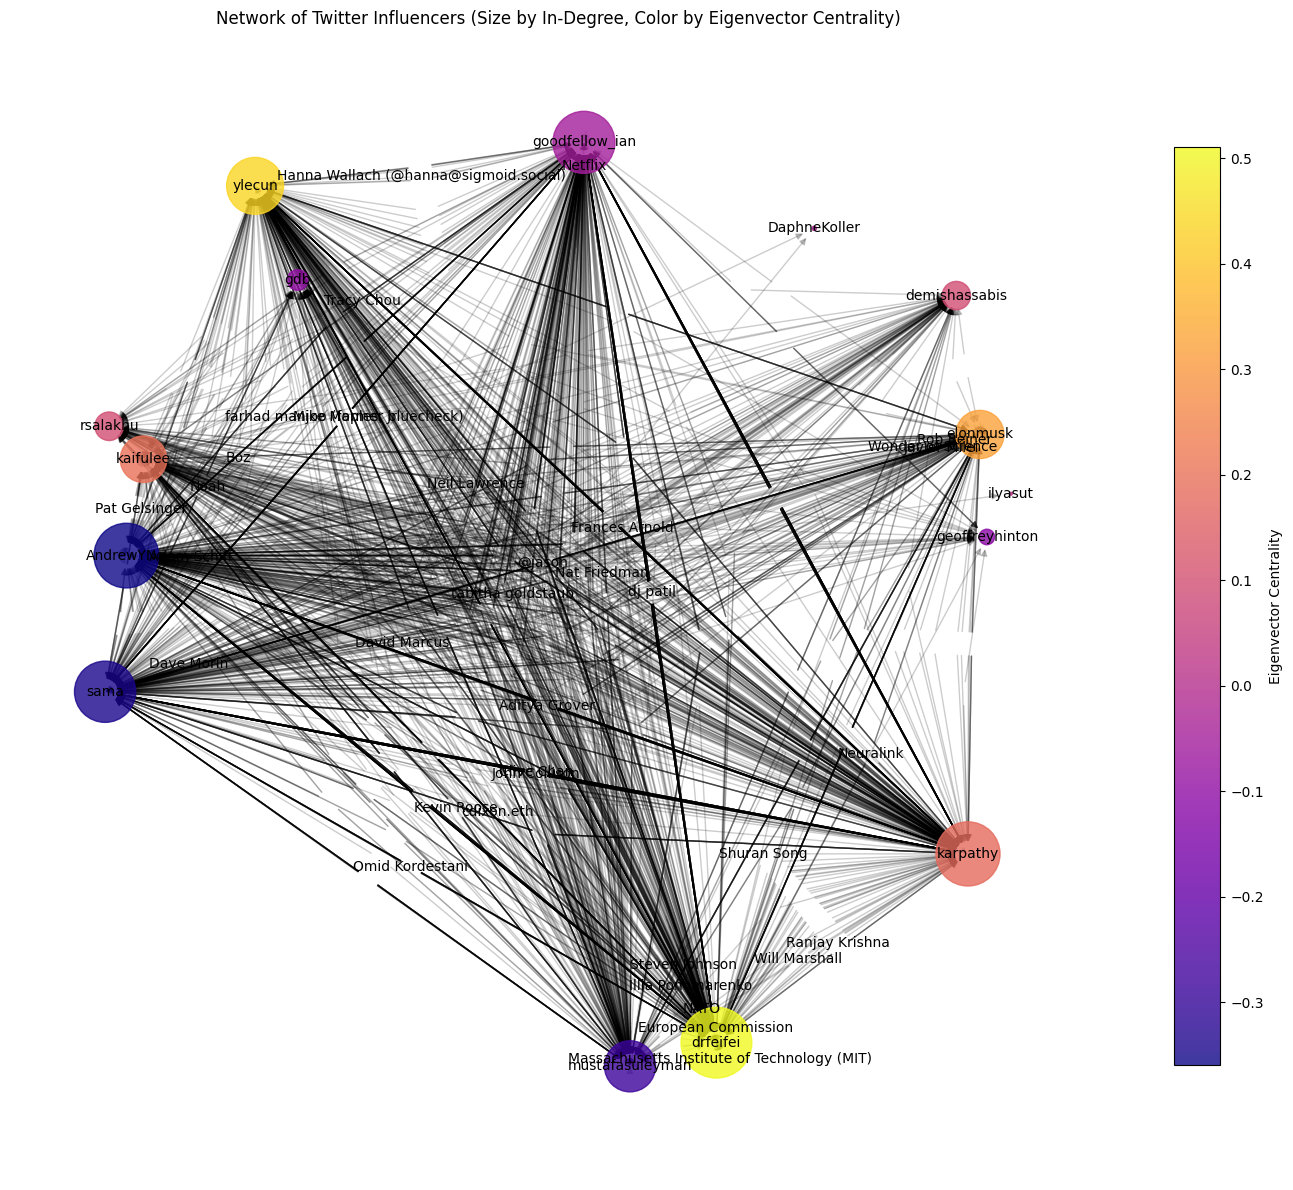

In [10]:
# Set up the graph visualization
fig, ax = plt.subplots(figsize=(14, 12))
pos = nx.spring_layout(G1, seed=42)  # positions for all nodes

# Nodes
node_sizes = [in_degree_centrality[n] * 7000 for n in G1]  # Scale in-degree centrality for visibility
node_colors = [eigenvector_centrality[n] for n in G1]  # Color by eigenvector centrality

# Draw the nodes
nodes = nx.draw_networkx_nodes(G1, pos, node_size=node_sizes, node_color=node_colors, 
                               cmap=plt.cm.plasma, alpha=0.8, ax=ax)

# Draw the edges
nx.draw_networkx_edges(G1, pos, alpha=0.2, ax=ax)

# Draw labels for top 50 by in-degree centrality
top_labels = {n: n for n in top50_nodes_by_in_degree.index}
nx.draw_networkx_labels(G1, pos, labels=top_labels, font_size=10, font_color='black', ax=ax)

# Colorbar for eigenvector centrality
plt.colorbar(nodes, label='Eigenvector Centrality', shrink=0.8)

ax.set_title('Network of Twitter Influencers (Size by In-Degree, Color by Eigenvector Centrality)')
plt.axis('off')  # Hide axes
save_fig('influencers_network')
plt.show()

In [11]:
top50_data = data[data['name_fo'].isin(top_labels.keys())][[
    'screenName_fo', 'name_fo', 'location', 'followersCount_fo', 'friendsCount_fo', 'tweetsCount_fo', 'ai_related', 'if personal account',
    'position_categorized', 'highest_level_org','name_kol','location_cleansed'
]].drop_duplicates('name_fo').set_index('screenName_fo')

# display(top50_data)

top50_data.shape

(35, 11)

Saving figure position_distribution


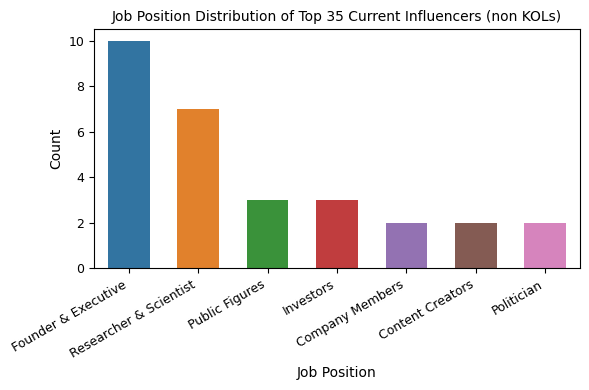

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Analyze the geographical distribution using the 'position_categorized' column
position_cat = top50_data['position_categorized'].value_counts()  # Top 50 positions

# Plotting the geographic distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=position_cat.index, y=position_cat.values, hue=position_cat.index, dodge=False, width=0.6)

# Adjusting font sizes
plt.title('Job Position Distribution of Top 35 Current Influencers (non KOLs)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Job Position', fontsize=10)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)

save_fig('position_distribution')
plt.tight_layout()
plt.show()

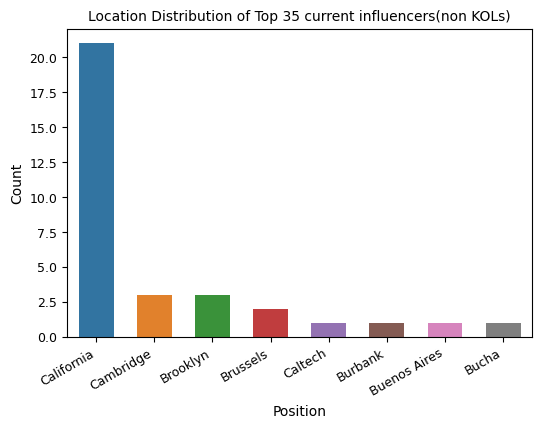

In [13]:
location_cat = top50_data['location_cleansed'].value_counts()  

plt.figure(figsize=(6,4))
sns.barplot(x=location_cat.index, y=location_cat.values, hue=location_cat.index, dodge=False,width=0.6)
plt.title('Location Distribution of Top 35 current influencers(non KOLs)', fontsize=10)
plt.xlabel('Position', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.show()

### 2. Current ai-influcencial persons (stand-alone user and non- KOLs) 

1. Construct the graph G5 (nodes : users , edges : A --> B from KOL to user) add attributes like follower count 
2. Calculate the influence score of each node
3. followersNorm = #followers / max followers
4. degreeNorm = #degree / maxdegree  
4. influence score = alpha * degreenorm + (1-alpha) * followersnorm



In [14]:
G5 = nx.DiGraph()

for _, row in data_cleaned.iterrows():
    if row['ai_related'] == 'Y':
        # G6.add_node(row['screenName_kol'], type='influencer')
        G5.add_node(row['name_fo'], type='following')
        G5.add_edge(row['name_kol'], row['name_fo'])
    
        G5.nodes[row['name_fo']]['followersCount'] = row['followersCount_fo']
        G5.nodes[row['name_fo']]['tweetsCount'] = row['tweetsCount_fo']
        G5.nodes[row['name_fo']]['friendsCount'] = row['friendsCount_fo']
        # G6.nodes[row['name_fo']]['certified'] = row['certified_kol']  # Verification status could also indicate influence


In [15]:
# Normalize metrics
max_followers = max(nx.get_node_attributes(G5, 'followersCount').values(), default=0)  # Adding default to handle empty cases
max_degree = max(nx.degree_centrality(G5).values(), default=0)  # Adding default to handle empty cases

for node in G5.nodes():
    followers_count = G5.nodes[node].get('followersCount', 0)  # Provide a default if missing
    followers_norm = followers_count / max_followers if max_followers > 0 else 0
    degree_norm = nx.degree_centrality(G5).get(node, 0) / max_degree if max_degree > 0 else 0
    G5.nodes[node]['influence_score'] = 0.5 * followers_norm + 0.5 * degree_norm

Influence Scores length: 614


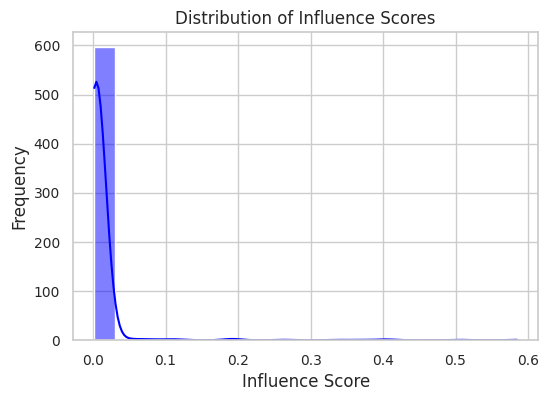

In [16]:
influence_scores = [G5.nodes[node]['influence_score'] for node in G5.nodes()]
print('Influence Scores length:',len(influence_scores))
sns.set(style="whitegrid")

# Plotting the distribution of influence scores with seaborn
plt.figure(figsize=(6, 4))  # Setting the figure size
sns.histplot(influence_scores, bins=20, kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Influence Scores', fontsize=12)
plt.xlabel('Influence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


In [17]:
# Finding top influencers within KOL's followings-top 200
top_influencers = sorted(G5.nodes(data=True), key=lambda x: x[1].get('influence_score', 0), reverse=True)[:200]

top_influencers_in_followings = pd.DataFrame({
    'Node': [node for node, data in top_influencers],
    'Influence Score': [data['influence_score'] for node, data in top_influencers],
    'Followers Count': [data.get('followersCount', 'N/A') for node, data in top_influencers]
})

# Exclude KOL
top_influencers_in_followings = top_influencers_in_followings[~top_influencers_in_followings['Node'].isin(KOL_list)].reset_index(drop = True)
print(top_influencers_in_followings.shape)

top_influencers_full = data_cleaned[data_cleaned['name_fo'].isin(top_influencers_in_followings['Node'])].drop_duplicates('name_fo').reset_index(drop = True)
print(top_influencers_full.shape)

top_influencers_person = top_influencers_full[top_influencers_full['if personal account'] == 'Y']
print(top_influencers_person.shape)

(186, 3)
(186, 38)
(150, 38)


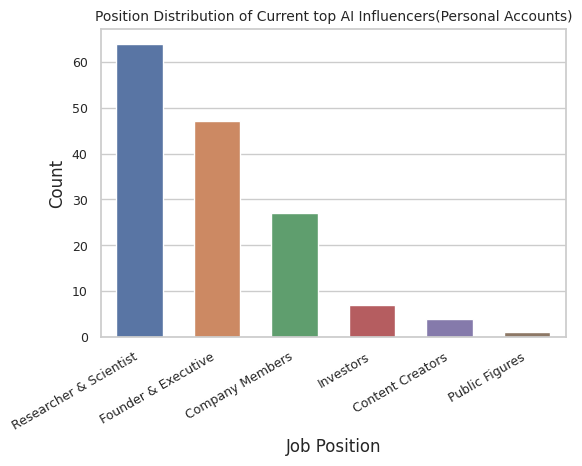

In [18]:
position_cat2 = top_influencers_person['position_categorized'].value_counts()  

plt.figure(figsize=(6, 4))
sns.barplot(x=position_cat2.index, y=position_cat2.values, hue=position_cat2.index, dodge=False, legend=False,width=0.6)
plt.title('Position Distribution of Current top AI Influencers(Personal Accounts)', fontsize=10)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Job Position', fontsize=12)
# save_fig('position_distribution2')
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.show()

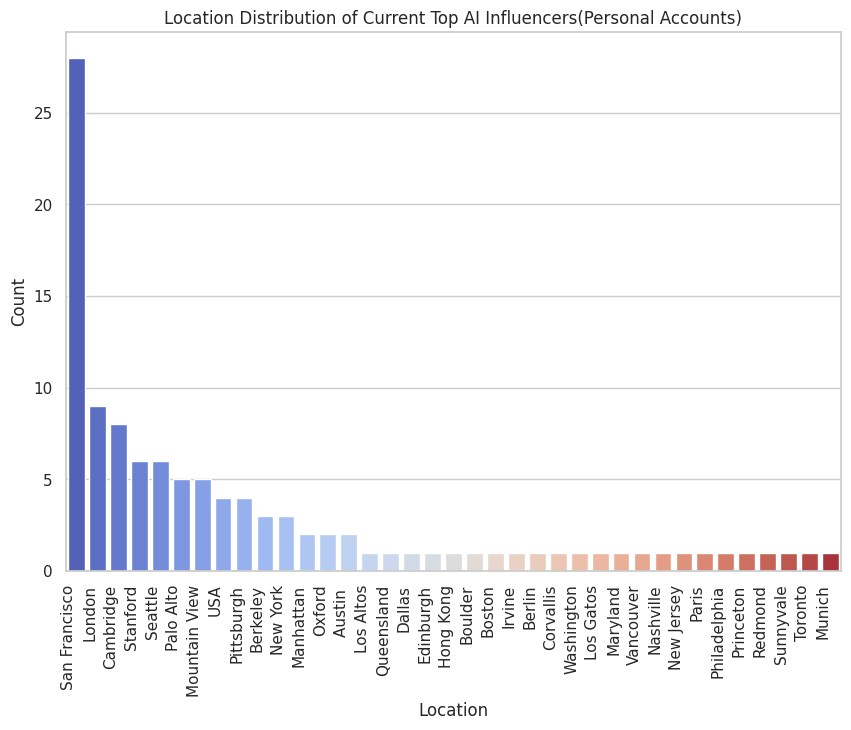

In [19]:
location_cat2 = top_influencers_person['location_cleansed'].value_counts()  

plt.figure(figsize=(10, 7))
sns.barplot(x=location_cat2.index, y=location_cat2.values, hue=location_cat2.index, palette='coolwarm', dodge=False, legend=False)
plt.title('Location Distribution of Current Top AI Influencers(Personal Accounts)')
plt.ylabel('Count')
plt.xlabel('Location')
plt.xticks(rotation=90, ha='right')
# save_fig('location_distribution2')
plt.show()

### 3. Finding Emergent ai influencers (personal account)

1. find the indegree of each node in G2 and no.of KOLs following him
2. Put a threshold for no.of followers(F) and no.of KOLs following(K)
3. if no.of followers for user < F and no.of KOLs following >= K
4. Those users are potential emergent ai influencer.

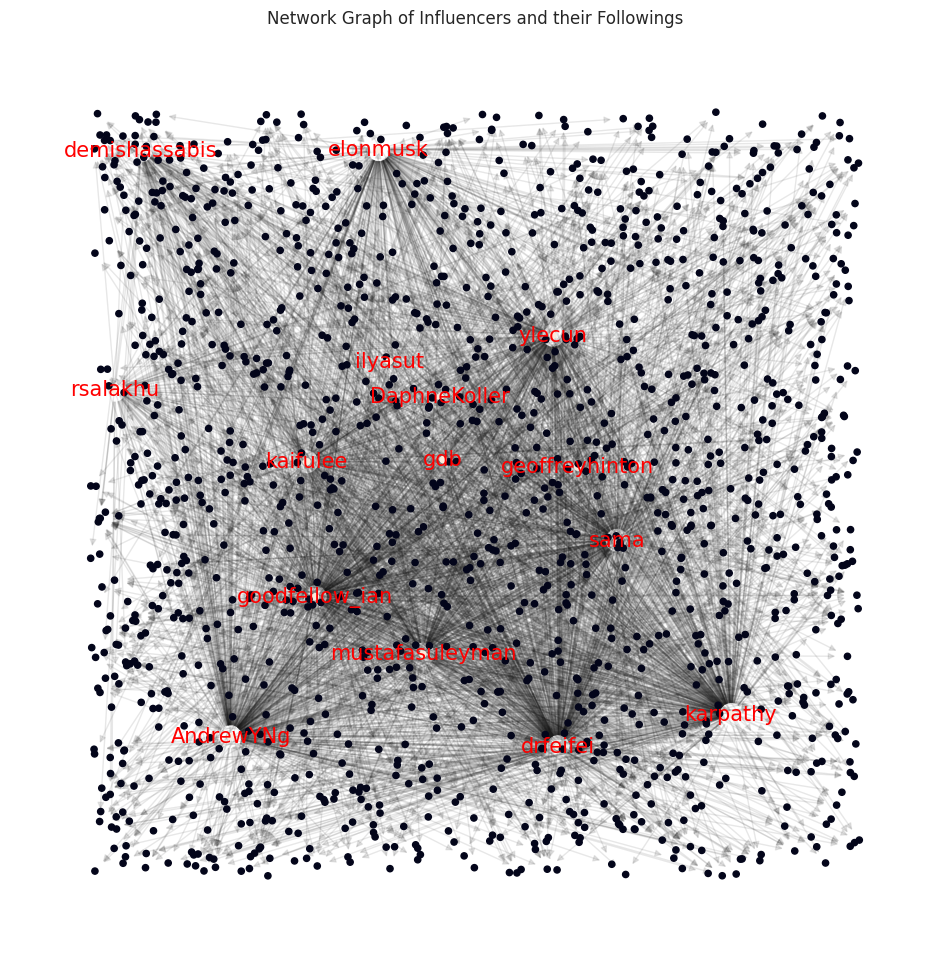

In [20]:
# Create a directed graph
G2 = nx.DiGraph()

# Add edges to the graph
for index, row in reformat_data.iterrows():
    G2.add_node(row['screenName_kol'], type='influencer')
    G2.add_node(row['name_fo'], type='following')
    G2.add_edge(row['screenName_kol'], row['name_fo'], follow_back=row['following_fo'])

# Define edge styles: solid for follow-back, dashed for not
edge_styles = {1: 'solid', 0: 'dashed'}
for u, v, d in G2.edges(data=True):
    G2[u][v]['style'] = edge_styles[d['follow_back']]

# Visualizing the network
plt.figure(figsize=(12, 12))
pos_random = nx.random_layout(G2, seed=42)  # Positions for all nodes

nx.draw_networkx_nodes(G2, pos_random, node_size=20, node_color=[G2.nodes[n]['type'] == 'influencer' for n in G2])
nx.draw_networkx_edges(G2, pos_random, alpha=0.1)
kol_labels = {node: node for node, data in G2.nodes(data=True) if data['type'] == 'influencer'}
nx.draw_networkx_labels(G2, pos_random, labels=kol_labels, font_size=15, font_color='red')

plt.title('Network Graph of Influencers and their Followings')
plt.axis('off')  # Turn off the axis
# save_fig('network_graph2')
plt.show()

In [21]:
# Calculate network metrics
degree_centrality = nx.degree_centrality(G2)
in_degree_centrality = nx.in_degree_centrality(G2)
out_degree_centrality = nx.out_degree_centrality(G2)
betweenness_centrality = nx.betweenness_centrality(G2)
eigenvector_centrality = nx.eigenvector_centrality(G2)
clossness_centrality = nx.closeness_centrality(G2)

# Prepare the data for display
centrality_measures = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'In-Degree Centrality': in_degree_centrality,
    'Out-Degree Centrality': out_degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Eigenvector Centrality': eigenvector_centrality,
    'Closeness Centrality': clossness_centrality
})


In [22]:
in_degree_df = pd.DataFrame.from_dict(in_degree_centrality, orient='index', columns=['centrality'])
# in_degree_df
in_degree_merged = pd.merge(data_cleaned, in_degree_df, left_on='name_fo', right_index=True, how='left')
in_degree_merged.shape

(3641, 39)

In [23]:
# Compute how many KOLs follow each person
followed_by = {fo: len(set(G2.predecessors(fo))) for fo in set(data_cleaned['name_fo'])}

# Merge this data back into the original DataFrame
kol_following_count = in_degree_merged[['name_fo', 'followersCount_fo', 'if personal account', 'ai_related', 'centrality']].drop_duplicates().copy()
kol_following_count['followed_by_kols'] = kol_following_count['name_fo'].map(followed_by)

# Filter to find users followed by many KOLs but with fewer followers and high centrality
threshold_followers = 5000  
threshold_kols = 2        
threshold_in_degree = 0.002

selected_people = kol_following_count[(kol_following_count['followed_by_kols'] >= threshold_kols) &
                        (kol_following_count['followersCount_fo'] < threshold_followers) & 
                        (kol_following_count['centrality'] > threshold_in_degree)]

print(selected_people.shape)

selected_people = selected_people[(selected_people['if personal account'] == 'Y') & (selected_people['ai_related'] == 'Y')].drop_duplicates(subset='name_fo')
print(selected_people.shape)

(16, 6)
(11, 6)


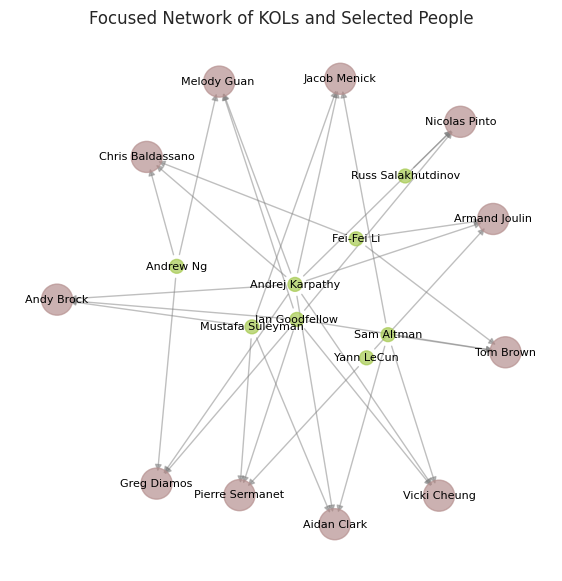

In [24]:
# Initialize a new directed graph
H = nx.DiGraph()

# Add only relevant nodes and edges
for _, row in data_cleaned.iterrows():
    if row['name_fo'] in selected_people['name_fo'].values:
        H.add_edge(row['name_kol'], row['name_fo'])

# Define node colors and sizes based on their role
node_colors = ['#b69190' if node in selected_people['name_fo'].values else '#a6ca50' for node in H.nodes()]
node_sizes = [500 if node in selected_people['name_fo'].values else 100 for node in H.nodes()]

# Visualize the network
plt.figure(figsize=(7, 7))  # Set the figure size
pos = nx.spring_layout(H)  # Node positions

nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(H, pos, edge_color='gray', width=1.0, alpha=0.5)
nx.draw_networkx_labels(H, pos, font_size=8, font_color='black')

plt.title('Focused Network of KOLs and Selected People')
plt.axis('off')  # Hide the axes
plt.show()

(11, 38)
Saving figure org_distribution2


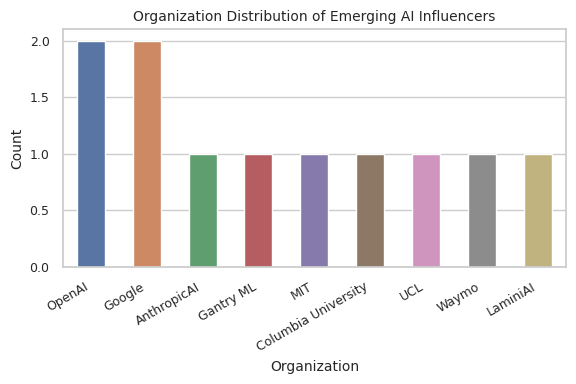

In [25]:
selected_people_info = data_cleaned[data_cleaned['name_fo'].isin(selected_people['name_fo'])].drop_duplicates(subset='name_fo').reset_index(drop=True)
print(selected_people_info.shape)

# organization they are working in
org_cat2 = selected_people_info['highest_level_org'].value_counts()  

plt.figure(figsize=(6, 4))
sns.barplot(x=org_cat2.index, y=org_cat2.values, hue=org_cat2.index, dodge=False, legend=False,width=0.5)
plt.title('Organization Distribution of Emerging AI Influencers', fontsize=10)
plt.xlabel('Organization', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
save_fig('org_distribution2')
plt.show()

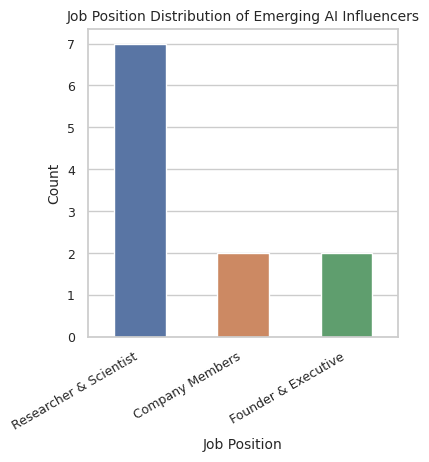

In [26]:
position_cat4 = selected_people_info['position_categorized'].value_counts()  

plt.figure(figsize=(4, 4))
sns.barplot(x=position_cat4.index, y=position_cat4.values, hue=position_cat4.index, dodge=False, legend=False,width=0.5)  
plt.title('Job Position Distribution of Emerging AI Influencers', fontsize=10)
plt.xlabel('Job Position', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
# save_fig('position_distribution')
plt.show()

## Q5. Finding different sub communities in ai domain.

1. Compute the clusters using greedy_modularity_communities algorithm 
2. Each cluster is represented with a node containing highest in-degree 

In [27]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

filtered_data= data[(data['ai_related'] == 'Y') & 
                               (data['position_categorized'] == 'Founder & Executive')]

G_ai = nx.DiGraph()


for index, row in filtered_data.iterrows():
    G_ai .add_node(row['screenName_fo'], label=row['name_fo'])
    G_ai .add_edge(row['screenName_kol'], row['screenName_fo'])

G_ai_undirected = G_ai.to_undirected()


communities_ai = list(greedy_modularity_communities(G_ai_undirected))
print(len(communities_ai))


central_nodes_corrected = {
    
}
for i, community in enumerate(communities_ai):
    subgraph = G_ai.subgraph(community)
    in_degrees = subgraph.in_degree()
    central_node = max(in_degrees, key=lambda x: x[1])[0]
    central_nodes_corrected[central_node] = i

G_ai.number_of_nodes(), G_ai.number_of_edges(), central_nodes_corrected, len(communities_ai)


5


(140,
 484,
 {'quocleix': 0, 'clmt': 1, 'ilyasut': 2, 'BillGates': 3, 'jackclarkSF': 4},
 5)

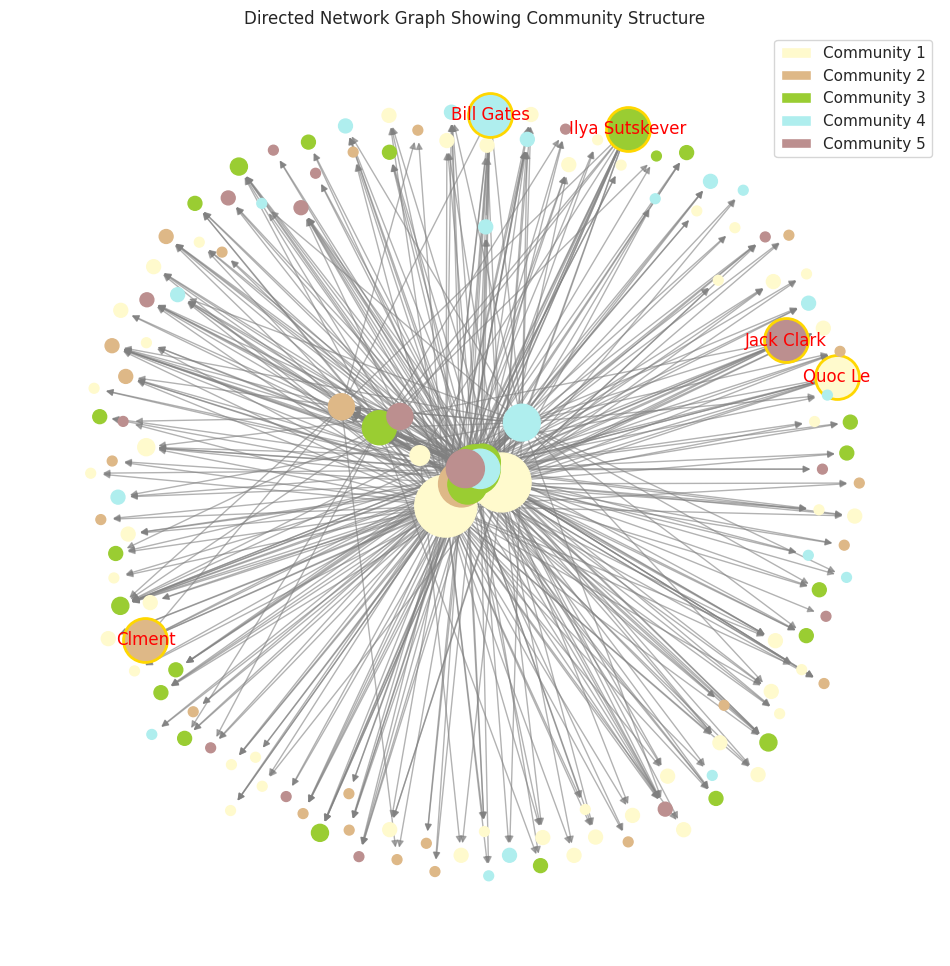

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def draw_directed_community_graph(G, communities):

    custom_colors = ['#FFFACD', '#DEB887', '#9ACD32', '#AFEEEE', '#BC8F8F', '#F08080']
    
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)  

    

    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color='gray', alpha=0.6)
    

    for i, community in enumerate(communities):
     
        subgraph = G.subgraph(community)
        in_degrees = subgraph.in_degree()
        center_node = max(in_degrees, key=lambda x: x[1])[0] # highest in-degree node of community

        sizes = [subgraph.degree(node) * 50 for node in subgraph.nodes()]

        # Draw nodes and labels
        community_color = custom_colors[i % len(custom_colors)]  
        nx.draw_networkx_nodes(subgraph, pos, node_color=community_color,node_size=sizes, label=f"Community {i+1}")

        #for highlighting the center_node
        nx.draw_networkx_nodes(subgraph, pos, nodelist=[center_node], node_color=community_color, node_size=1000, edgecolors='gold', linewidths=2,)
        nx.draw_networkx_labels(subgraph, pos, labels={center_node: G.nodes[center_node]['label']}, font_color='red')


    legend_handles = [Patch(facecolor=custom_colors[i % len(custom_colors)], label=f"Community {i+1}") for i in range(len(communities))]
    plt.legend(handles=legend_handles, loc='upper right')
    
    plt.title("Directed Network Graph Showing Community Structure")
    plt.axis('off')
    plt.show()

draw_directed_community_graph(G_ai, communities_ai)

In [29]:
# The end